# Fear Conditioning, Extinction, and Renewal in the Amygdala

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
class Inputs():
    def __init__(self, nCS=3, nCTX=3, dim=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim = dim
        self.nCS = nCS
        self.nCTX = nCTX
        self.CSs = self.sampler.sample(nCS, dim, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim, rng=self.rng)
        self.USs = self.rng.randint(2, size=nCS)
        self.experiment = None
    def get_CS(self, t):
        if self.experiment == "baseline":
            idx = int(t) % self.nCS
            return self.CSs[idx]
        elif self.experiment == "conditioning":
            idx = int(t/3) % self.nCS
            applied = True if t%3>1 else False  # 1s of no input, 2s of CS input
            return self.CSs[idx] if applied else np.zeros((dim))
        elif self.experiment == "expression":
            idx = int(t/2) % self.nCS
            applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
            return self.CSs[idx] if applied else np.zeros((dim))
        else:
            return np.zeros((dim))
    def get_CTX(self, t):
        idx = int(t) % self.nCS
        return self.CTX[idx]
    def get_US(self, t):
        if self.experiment == "baseline":
            return 0
        elif self.experiment=="conditioning":
            idx = int(t/3) % self.nCS
            applied = True if t%3>2 else False # 2s of no input, 1s of US input 
#             return self.USs[idx] if applied else 0
            return 1 if applied else 0
        elif self.experiment == "expression":
            return 0
        else:
            return 0
    def shuffle_CS_US(self):
        indices = np.arange(self.nCS)
        self.rng.shuffle(indices)
        self.CSs = self.CSs[indices]
        self.USs = self.USs[indices]

In [66]:
seed = 0
stimulus_seed = 3
dim = 3
nCS = 4
nPairings = 5
nNeurons = 1000
tau = 0.1

net = nengo.Network(seed=seed)
inputs = Inputs(nCS=nCS, dim=dim, seed=stimulus_seed)
a = np.dot(inputs.CSs, inputs.CSs.T).shape
intercept = (np.dot(inputs.CSs, inputs.CSs.T) - np.eye(nCS)).flatten().max()

with net:
    # inputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    # learning rules
    voja = nengo.Voja(learning_rate=2e-2, post_synapse=None)
    # ensembles
#     LA_CS = nengo.Ensemble(nNeurons, dim, intercepts=[intercept]*nNeurons)
    LA_CS = nengo.Ensemble(nNeurons, dim)
    LA_US = nengo.Ensemble(nNeurons, 1)
    # connections
    cCS = nengo.Connection(CS, LA_CS, synapse=None, learning_rule_type=voja)
    cUS = nengo.Connection(US, LA_US, synapse=None)
    cCoincident = nengo.Connection(LA_US, cCS.learning_rule, synapse=None, function=lambda x: x-1)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pLA_CS = nengo.Probe(LA_CS.neurons, synapse=tau)
    pEncoders = nengo.Probe(cCS.learning_rule, "scaled_encoders")

## Experiment 1: measure firing rates of LA neurons before and after conditioning training

In [67]:
dt = 0.001
t_baseline = nCS
t_conditioning = 3*nCS
t_expression = 2*nCS

sim = nengo.Simulator(net, dt=dt)
with sim:
    inputs.experiment = "baseline"
    sim.run(t_baseline)
    inputs.experiment = "conditioning"
    for p in range(nPairings):
        inputs.shuffle_CS_US()
        sim.run(t_conditioning)
    inputs.experiment = "expression"
    inputs.shuffle_CS_US()
    sim.run(t_expression)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [68]:
T_baseline = int(t_baseline/dt)
T_expression = int(t_expression/dt)

dAs_control = []
dAs_baseline = []
for n in range(nCS):
    CSns_baseline = np.array([inputs.CSs[n]]*T_baseline)
    CSns_expression = np.array([inputs.CSs[n]]*T_expression)
    zeros_expression = np.array([np.zeros((dim))]*T_expression)
    
    idx_CSn_baseline = np.where(CSns_baseline==sim.data[pCS][:T_baseline])[0]
    idx_CSn_expression = np.where(CSns_expression==sim.data[pCS][-T_expression:])[0]
    idx_CSn_control = np.where(zeros_expression==sim.data[pCS][-T_expression:])[0]
    
    A_CSn_baseline = sim.data[pLA_CS][:timesteps][idx_CSn_baseline]
    A_CSn_expression = sim.data[pLA_CS][-timesteps:][idx_CSn_expression]
    A_CSn_control = sim.data[pLA_CS][-timesteps:][idx_CSn_control]
    
    dAs_baseline.append(np.mean(A_CSn_expression, axis=0) - np.mean(A_CSn_baseline, axis=0))
    dAs_control.append(np.mean(A_CSn_expression, axis=0) - np.mean(A_CSn_control, axis=0))

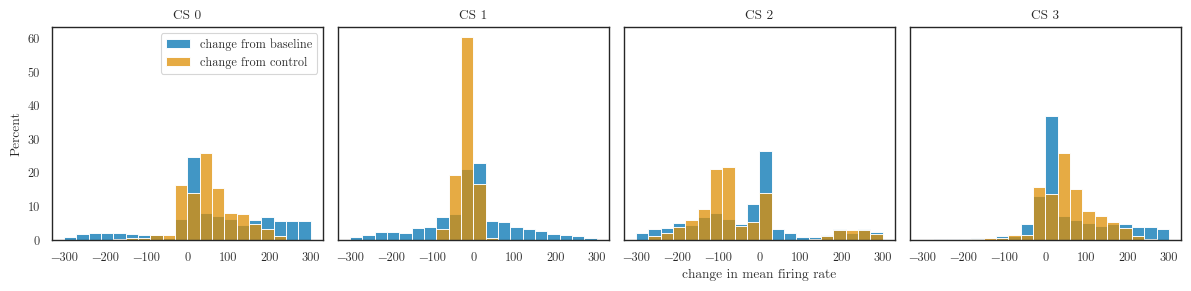

In [69]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

fig, axes = plt.subplots(nrows=1, ncols=nCS, figsize=((3*nCS,3)), sharey=True)
for n in range(nCS):
    sns.histplot(dAs_baseline[n], ax=axes[n], bins=20, binrange=[-300,300], stat='percent', label='change from baseline', color=palette[0])
    sns.histplot(dAs_control[n], ax=axes[n], bins=20, binrange=[-300,300], stat='percent', label='change from control', color=palette[1])
    axes[n].set(title=f'CS {n}')
axes[0].legend()
axes[int(nCS/2)].set(xlabel='change in mean firing rate', ylabel='percent of neurons')
plt.tight_layout()

In [70]:
'''2D CS'''
# scale = (sim.data[LA_CS].gain / LA_CS.radius)[:, np.newaxis]
# encoders_before = sim.data[pEncoders][0].copy() / scale
# encoders_after = sim.data[pEncoders][-1].copy() / scale

# palette = sns.color_palette("colorblind")
# sns.set_palette(palette)
# sns.set(context='paper', style='white', font='CMU Serif')

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((8,4)), sharey=False)
# for n in range(nCS):
#     CS = inputs.CSs[n]
#     m = [(3,1,0), (4,1,0), (5,1,0)][n]
#     c = palette[3] if inputs.USs[n] else palette[2]
#     axes[0].scatter(CS[0], CS[1], zorder=1, color=c, s=400, marker=m)
#     axes[1].scatter(CS[0], CS[1], zorder=1, color=c, s=400, marker=m)
# axes[0].scatter(encoders_before[:,0], encoders_before[:,1], color=palette[0], alpha=0.3)
# axes[1].scatter(encoders_after[:,0], encoders_after[:,1], color=palette[0], alpha=0.3)
# axes[0].set(xticks=((-1,1)), xlim=((-1.1,1.1)), yticks=((-1,1)), ylim=((-1.1,1.1)), title='encoders before')
# axes[1].set(xticks=((-1,1)), xlim=((-1.1,1.1)), yticks=((-1,1)), ylim=((-1.1,1.1)), title='encoders after')
# plt.tight_layout()

'2D CS'

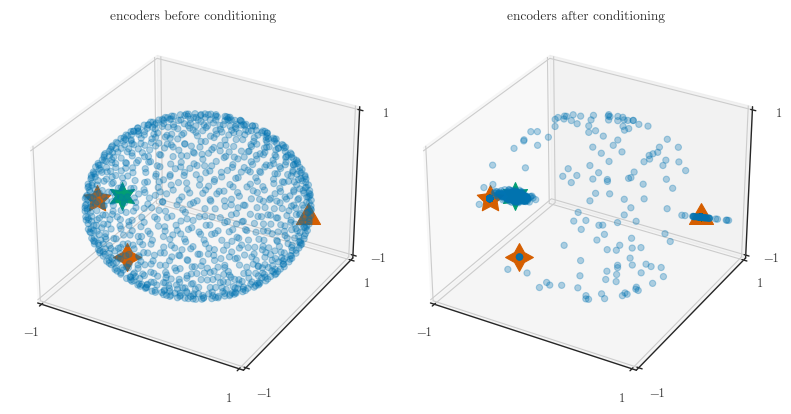

In [80]:
'''3D CS'''
scale = (sim.data[LA_CS].gain / LA_CS.radius)[:, np.newaxis]
encoders_before = sim.data[pEncoders][0].copy() / scale
encoders_after = sim.data[pEncoders][-1].copy() / scale

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

fig = plt.figure(figsize=((8,4)))
ax = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
markers = [(3+n, 1, 0) for n in range(nCS)]
for n in range(nCS):
    CS = inputs.CSs[n]
    m = markers[n]
    c = palette[3] if inputs.USs[n] else palette[2]
    ax.scatter(CS[0], CS[1], CS[2], zorder=1, color=c, s=400, marker=m)
    ax2.scatter(CS[0], CS[1], CS[2], zorder=1, color=c, s=400, marker=m)
ax.scatter(encoders_before[:,0], encoders_before[:,1], encoders_before[:,2], color=palette[0], alpha=0.3)
ax2.scatter(encoders_after[:,0], encoders_after[:,1], encoders_after[:,2], color=palette[0], alpha=0.3)
# ax.set(xticks=((-1,1)), xlim=((-1.1,1.1)), yticks=((-1,1)), ylim=((-1.1,1.1)), title='encoders before')
# ax1.set(xticks=((-1,1)), xlim=((-1.1,1.1)), yticks=((-1,1)), ylim=((-1.1,1.1)), title='encoders after')
ax.set(title="encoders before conditioning", xlim=((-1, 1)), xticks=((-1,1)), ylim=((-1, 1)), yticks=((-1,1)), zlim=((-1, 1)), zticks=((-1,1)))
ax2.set(title="encoders after conditioning", xlim=((-1, 1)), xticks=((-1,1)), ylim=((-1, 1)), yticks=((-1,1)), zlim=((-1, 1)), zticks=((-1,1)))
plt.tight_layout()